In [1]:
import synapseclient 
import synapseutils 

syn = synapseclient.Synapse() 
files = synapseutils.syncFromSynapse(syn, ' syn51400754 ') 

ValueError: Cannot initiate a sync from an entity that is not a File or Folder

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from sklearn.preprocessing import StandardScaler
import umap

In [ ]:
from load_data import AMLData,  cluster_colors
from load_data_from_synpase import load_file, load_table

In [64]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['font.family'] = ['arial']
matplotlib.rcParams['font.size'] = 6

sns.set_theme(context ='paper', 
    palette="Paired", 
    style='white',
    font='arial',
    font_scale=1.0)

In [3]:
drugs_to_focus = [
    'Panobinostat',
    'Gilteritinib',
    'Venetoclax',
    'Sorafenib',
    'Quizartinib (AC220)',
    'Trametinib (GSK1120212)',
]

In [4]:
syn_id = 'syn30029402'
features = load_file(syn_id)
features

,Cluster,Gene,alpha,data_type
19362,1,ALKBH5,0.9,Global + Phospho
19363,1,APOOL,0.9,Global + Phospho
19364,1,ATG2B,0.9,Global + Phospho
19365,1,CRYZL1,0.9,Global + Phospho
19366,1,DAZAP2,0.9,Global + Phospho
...,...,...,...,...
7605,4,COMTD1,0.7,RNA
7606,4,TNIK,0.7,RNA
7607,4,PENK,0.7,RNA
7608,4,PRRT3,0.7,RNA


In [5]:
used_feat = features.loc[features.alpha == .9].copy()

In [6]:
used_feat_list = used_feat.Gene.values
used_feat_list = list(used_feat_list)
final = []
for i in set(used_feat_list):
    if '-' not in i:
        i = f'{i}_prot'
    final.append(i)
print(len(final))

147


In [7]:
# point of access for all data
data = AMLData()

significant not in columns.
p_value not in columns.


In [8]:
def plot_all_features(features):
    node_labels = data.meta['Cluster']
    node_labels.dropna(inplace=True)

    node_lut = dict(zip(sorted(node_labels.unique()), cluster_colors))

    node_colors = pd.Series(node_labels, index=data.meta.index.values, name='Cluster').map(node_lut)
    handles = [Patch(facecolor=node_lut[name]) for name in node_lut]
    
    test = data.exp_data.species.subset(
        features,
        index='label'
    )
    prot = test.pivoter(
        index='label', 
        values='exp_value',
        columns='sample_id'
    )
    print(prot.shape)
    return prot
    vmax = max(
        abs(prot.quantile(0.2).min()), 
        prot.quantile(0.8).max()
    )
    vmax=2

    print(prot.quantile(0.1).min())
    print(prot.quantile(0.99).max())
    print(prot.max().max())
    print(vmax)
    sns.clustermap(
        prot.fillna(0),
        mask=prot.isnull(),
        figsize=(12, 12),
        z_score=0,
        row_cluster=True,
        col_cluster=True,
        method='ward',
        metric='correlation',
        col_colors= node_colors,
        vmax=vmax, 
        vmin=-1*vmax,
        yticklabels=False,
        xticklabels=False,
        cmap=sns.color_palette("RdBu_r", 11)
    #     linewidths=0.001

    )

    plt.legend(
        handles, node_lut, title='Cluster',
        bbox_to_anchor=(1.1, .8),
        bbox_transform=plt.gcf().transFigure,
        loc='upper right'
    )
    return prot

In [9]:
used_feat_df = plot_all_features(
    final
)
#plt.savefig("en_used_features_heatmap.png", bbox_inches='tight', dpi=300)

(146, 210)


In [10]:
umap_scaled = StandardScaler().fit_transform(used_feat_df.dropna(axis=1).T)
reducer = umap.UMAP(
    n_neighbors=10,
    n_components=2,
#     metric='correlation'

)
X_embedded = reducer.fit_transform(umap_scaled)
principalDf = pd.DataFrame(
    data = X_embedded,
    columns = [f'pc{i}' for i in range(1, X_embedded.shape[1]+1)],
    index=used_feat_df.T.index
)
umap_df = pd.concat([principalDf, data.auc_table[drugs_to_focus], data.meta['Cluster']], axis = 1)

(210, 2)

,pc1,pc2
sample_id,,
11-00261,1.262075,6.772578
11-00376,5.047512,5.817535
11-00378,4.927723,5.393238
11-00382,1.534649,8.002012
11-00388,1.244441,8.024945


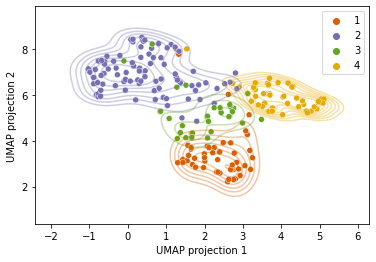

In [13]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)

sns.kdeplot(
    data=umap_df, x='pc1', y='pc2', color='black',  
    thresh=0.2,
    levels=8, 
#     bw_adjust=1.,
    fill=False,  
    alpha=0.35,
    hue='Cluster',
    palette=cluster_colors,
    ax=ax
)


sns.scatterplot(
    data=umap_df,
    x='pc1', y='pc2',
    hue='Cluster',
    palette=cluster_colors,
    ax=ax
)

plt.legend(bbox_to_anchor=(1., 1.))
plt.xlabel("UMAP projection 1");
plt.ylabel("UMAP projection 2");

#plt.savefig("umap_cluster_landscape_from_en.png", bbox_inches='tight', dpi=300)
#plt.savefig("umap_cluster_landscape_from_en.pdf", bbox_inches='tight', dpi=300)

In [ ]:
umap_df.dropna(subset=['Venetoclax', 'Panobinostat'],  inplace=True)

umap_df['vent_sens'] = False
umap_df.loc[umap_df.Venetoclax<100, 'vent_sens'] = True

umap_df['pano_sens'] = False
umap_df.loc[umap_df.Panobinostat<100, 'pano_sens'] = True

umap_df['sor_sens'] = False
umap_df.loc[umap_df.Sorafenib<100, 'sor_sens'] = True

# del umap_df['sens_both'] 
umap_df.loc[umap_df.pano_sens, 'sens_both'] ='Panobinostat'
umap_df.loc[umap_df.vent_sens, 'sens_both'] = 'Venetoclax'


umap_df.loc[(umap_df.Panobinostat<100) &  (umap_df.Venetoclax<100), 'sens_both'] = 'Both'
umap_df.loc[(umap_df.Panobinostat>100) &  (umap_df.Venetoclax>100), 'sens_both'] = 'Neither'

umap_df.loc[(umap_df.Panobinostat.isna()) &  (umap_df.Venetoclax.isna()), 'sens_both'] ='Not measured'
umap_df.head()

[WARNING] C:\Users\pino216\Miniconda3\envs\beatAML_env_37\lib\site-packages\seaborn\distributions.py:1213: UserWarning:

No contour levels were found within the data range.




['Venetoclax', 'Panobinostat', 'Neither', 'Both']


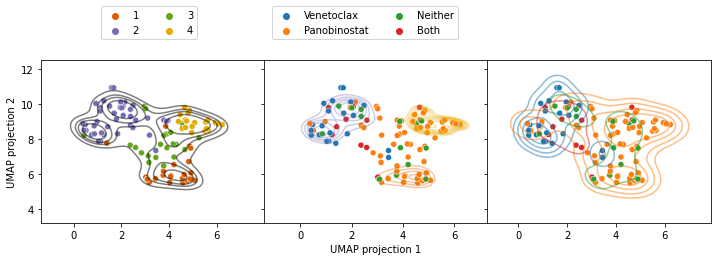

In [32]:
f, (ax1, ax2, ax3) = plt.subplots(
    1, 3,
    sharey=True,
    figsize=(12, 3)
)

g1 = sns.kdeplot(
    data=umap_df, 
    x='pc1', y='pc2', 
    color='black',  
    thresh=0.2, 
    levels=5, 
    bw_adjust=.8,
    fill=False, 
    alpha=0.5, 
    ax=ax1, 
    legend=False
)

g1 = sns.scatterplot(
    data=umap_df,
    x='pc1', y='pc2', 
    hue='Cluster',
    palette=cluster_colors,
    ax=ax1
)
sub = umap_df.loc[umap_df.sens_both.isin([
    'Panobinostat', 'Venetoclax',
    'Both', 
    'Neither'
    
])]

g2 = sns.kdeplot(
    data=umap_df, 
    x='pc1', y='pc2', 
    color='black',
    thresh=0.4,
    levels=8, 
    bw_adjust=1,
    fill=False,  
    alpha=0.35,
    ax=ax2,  
    hue='Cluster', 
    legend=False,
    palette=cluster_colors,
)
sns.scatterplot(
    data=sub,
    x='pc1', y='pc2',
    hue='sens_both', 
    ax=ax2,
    legend=False
);

sns.kdeplot(
    data=sub,
    x='pc1', y='pc2',
    color='black',   
    thresh=0.2, 
    levels=5,
    bw_adjust=.8,
    fill=False,
    hue='sens_both',
    alpha=0.5,
    ax=ax3,
    legend=False
);

sns.scatterplot(
    data=sub,
    x='pc1', y='pc2',
    hue='sens_both', 
    ax=ax3,
    legend=True
);


# sns.move_legend(g1, "upper left", bbox_to_anchor=(1, 1))
ax2.set_xlabel("UMAP projection 1")
ax1.set_ylabel("UMAP projection 2");
ax1.set_xlabel('')
ax3.set_xlabel('')
ax2.set_ylabel('')
ax3.set_ylabel('')
# plt.subplots_adjust()
f.subplots_adjust(wspace=0)
handles, labels = ax1.get_legend_handles_labels()
leg = f.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(.25, 1.15))
ax1.get_legend().remove()

handles, labels = ax3.get_legend_handles_labels()
print(labels)
leg = f.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(.5, 1.15))
ax3.get_legend().remove()
# plt.savefig('sens_landscape_vent_pano.png', dpi=300, bbox_inches='tight', bbox_extra_artists=(leg,))

In [15]:
def load_q_treated():
    q_proteomics = load_table('syn23595222')
    q_proteomics['label'] = q_proteomics['Gene'] + '_prot'
    proteomics_mapper = {
        'Gene': 'identifier',
        'value': 'exp_value',
    }
    q_proteomics.rename(proteomics_mapper, axis=1, inplace=True)
    
    q_phospho = load_table('syn23595223')
    
    phosp_mapper = {
            'Gene': 'gene_symbol',
            'site': 'label',
            'value': 'exp_value',
        }
    q_phospho.rename(phosp_mapper, axis=1, inplace=True)
    
    quiz_data = pd.concat([q_phospho, q_proteomics])

    quiz_data.loc[quiz_data['cellLine'] == 'MOLM14', 'cellLine'] = 'Naive'
    quiz_data.loc[quiz_data['cellLine'] == 'EARLY Quizartinib Resistance MOLM14', 'cellLine'] = 'Early'
    quiz_data.loc[quiz_data['cellLine'] == 'LATE Quizartinib Resistance MOLM14', 'cellLine'] = 'Late '
    quiz_data.loc[quiz_data['cellLine'] == 'RESISTANT MOLM14', 'cellLine'] = 'Resistant'
    
    quiz_data['sample_id'] = quiz_data['Sample'] + '_' + \
                             quiz_data['Ligand'] + '_' + \
                             quiz_data['cellLine']
    
    qd = quiz_data.pivot_table(
        index='sample_id',
        columns='label', 
        values='exp_value'
    )
    return qd

def align_cell_line_to_patients(patient, cell_line):
    patient_ids = set(patient.columns.values)
    cell_line_ids = set(cell_line.columns.values)
    in_both = patient_ids.intersection(cell_line_ids)
    merged = pd.concat([patient, qd[in_both]])
    cell_line_labels = cell_line.index.values
    patient_labels = patient.index.values
    return merged, cell_line_labels, patient_labels

In [16]:
qd = load_q_treated()

Loading syn23595222
Loading syn23595223


In [ ]:
df_subset = data.get_trainable_data(['proteomics', 'phospho'], 'Venetoclax', new_format=True)

,DCAF7_prot,DOK2_prot,UFL1-S462s,BLMH_prot,CISD1_prot,CLNS1A-S102s,PAAF1_prot,PCCB_prot,NAA38_prot,C17orf49-S84s,...,GSK3B-Y216y,CFH_prot,CHAMP1-S416s,FLII-S436s,KDM6A_prot,LYRM4_prot,SRSF6-S45s,PITPNC1_prot,ANP32A_prot,LCP1-S5s
sample_id,,,,,,,,,,,,,,,,,,,,,
14-00817,0.145,0.396,0.5760,-0.2580,0.0914,0.1770,0.273,0.223,-0.2090,-0.546,...,-0.00859,1.520,-0.159,-0.9420,-0.1980,-0.4970,0.55600,-0.316,-0.1480,-0.0968
15-00043,-0.471,0.978,-1.5000,-0.5220,-0.6230,-0.2630,0.268,-0.349,-0.7460,-0.643,...,1.07000,0.853,0.535,-0.6490,0.2080,-0.0939,-0.34000,0.346,-0.4120,0.3170
15-00051,0.192,-0.869,-0.9010,-0.2870,0.4200,0.6850,-0.242,0.118,0.0500,-0.448,...,-0.08230,-1.140,-0.143,-1.3500,0.0383,-0.2430,-0.34200,-0.685,0.0752,-0.3990
15-00276,-0.105,1.180,0.2040,0.0422,-0.0325,-0.0533,0.158,0.393,-0.0532,-0.366,...,0.18200,-0.174,0.164,0.6660,-0.2390,-0.1120,-0.07160,0.371,-0.2100,1.1900
15-00287,0.482,-0.611,0.0512,-0.2730,0.0173,-0.1870,0.281,-1.410,0.0912,0.628,...,-0.13600,-1.160,-0.012,-0.0563,-0.0108,-0.4020,0.00954,0.785,0.5850,-0.2920


In [25]:
all_protein = data.subset(['proteomics', 'phospho'])
all_protein.set_index('sample_id', inplace=True)
all_protein.head()

label,A2M_prot,AAAS-S495s,AAAS-S541s,AAAS_prot,AACS_prot,AAGAB_prot,AAK1-S18s,AAK1-S20s,AAK1-S21s,AAK1-S637s,...,ZYX-Y172y,ZYX_prot,ZZEF1-S1464s,ZZEF1-S1518s,ZZEF1-S2526s,ZZEF1-T1512tS1518s,ZZEF1_prot,ZZZ3-S314s,ZZZ3_prot,hCG_2039718-S157s
sample_id,,,,,,,,,,,,,,,,,,,,,
11-00261,-0.497,1.190,NaN,-0.2700,-0.471,-0.3200,-0.5860,-0.3920,-0.6180,-0.0456,...,-0.365,-0.0746,-1.0700,-0.0727,-0.8070,-0.154,-0.1930,1.090,0.6490,0.477
11-00376,-0.267,NaN,NaN,-0.1080,0.906,0.1720,0.0874,1.1400,0.5680,1.5600,...,-0.304,0.3680,1.4900,0.6160,0.3190,1.390,0.4390,NaN,-0.0200,-0.226
11-00378,1.860,NaN,-0.2500,0.0669,1.160,0.0781,0.0812,0.0695,-0.1820,1.2800,...,0.367,0.8890,0.8970,0.3660,-0.4400,NaN,0.4710,0.429,-0.0332,0.501
11-00382,-0.752,-2.770,NaN,0.0232,0.326,-0.1140,0.7400,0.5100,-0.0829,0.5300,...,NaN,0.1130,0.7470,2.0300,-0.0116,NaN,0.0979,NaN,-0.0349,1.050
11-00388,-0.196,0.427,-0.0715,0.0413,0.425,0.1040,NaN,1.5700,1.5100,-3.0700,...,NaN,-0.1160,0.0619,3.2100,0.2210,NaN,0.3530,0.141,-0.0333,-1.240


In [ ]:
merged, cell_line_labels, patient_labels = align_cell_line_to_patients(all_protein, qd)

In [42]:
merged

label,RALA_prot,LUC7L3_prot,LMO7_prot,BLMH_prot,IGLC2_prot,CPQ_prot,EEF1D-S549s,NUFIP2-S572s,EEF2K_prot,HPDL_prot,...,SERF2_prot,MEMO1_prot,RBM15-S670sS674s,ABI3_prot,KCTD12_prot,MIB1_prot,MTHFS_prot,CRYZL1_prot,P3H1_prot,PRG2_prot
sample_id,,,,,,,,,,,,,,,,,,,,,
11-00261,-0.478,0.23900,-0.19400,0.06680,-1.570,-0.6750,-0.493,-0.433,1.0500,0.3780,...,0.1240,-0.0399,0.004830,0.805,0.00533,-0.3900,0.2770,-0.0294,-0.25400,-0.345
11-00376,-0.314,0.05300,-0.08900,-0.28400,1.490,0.1090,0.547,1.390,0.1840,-0.6080,...,0.4830,-0.3800,-0.268000,0.365,0.82000,0.3410,0.0108,0.0333,0.18200,-0.173
11-00378,-0.113,-0.23300,0.62300,-0.28600,2.530,0.3900,0.654,0.953,-0.0965,-1.6900,...,-0.8370,-0.1380,-0.697000,1.290,2.49000,-0.3580,-0.0460,0.5150,0.14000,1.880
11-00382,-0.119,-0.07020,0.91900,-0.21000,-0.291,-0.5290,-0.604,0.552,0.3480,0.0209,...,0.2600,0.6290,0.175000,-0.390,-0.89300,0.2190,-0.3010,-0.1400,0.59900,0.131
11-00388,-0.127,0.14800,0.75600,-0.64500,-0.600,-1.1600,-0.924,-0.440,0.2660,1.4000,...,0.8440,0.1770,0.795000,0.192,-1.64000,0.1710,-0.1380,-0.3420,1.06000,0.264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P6.5_FGF2_Late,0.295,0.03570,0.26600,0.07620,NaN,-0.3010,NaN,-0.266,-0.0797,0.2200,...,-0.0167,-0.1810,-0.291667,NaN,0.23800,-0.0274,-0.5500,-0.1750,-0.08980,NaN
P6.6_FGF2_Late,0.166,0.15800,0.39750,0.01250,NaN,-0.6390,NaN,-0.200,0.0154,0.5470,...,-0.1340,-0.1870,0.150667,NaN,0.27000,-0.0579,-0.7130,-0.2700,0.06240,NaN
P6.7_FLT3 ligand_Late,0.147,-0.25900,0.47450,0.07080,NaN,-0.1860,NaN,-0.385,-0.2070,0.0305,...,-0.4320,-0.1700,-0.143000,NaN,0.01730,0.1110,-0.4840,-0.2520,0.02720,NaN


In [43]:
merged = merged[list(set(final).intersection(merged.columns.values))].copy()


In [44]:
merged

label,RALA_prot,LUC7L3_prot,LMO7_prot,BLMH_prot,IGLC2_prot,CPQ_prot,EEF1D-S549s,NUFIP2-S572s,EEF2K_prot,HPDL_prot,...,SERF2_prot,MEMO1_prot,RBM15-S670sS674s,ABI3_prot,KCTD12_prot,MIB1_prot,MTHFS_prot,CRYZL1_prot,P3H1_prot,PRG2_prot
sample_id,,,,,,,,,,,,,,,,,,,,,
11-00261,-0.478,0.23900,-0.19400,0.06680,-1.570,-0.6750,-0.493,-0.433,1.0500,0.3780,...,0.1240,-0.0399,0.004830,0.805,0.00533,-0.3900,0.2770,-0.0294,-0.25400,-0.345
11-00376,-0.314,0.05300,-0.08900,-0.28400,1.490,0.1090,0.547,1.390,0.1840,-0.6080,...,0.4830,-0.3800,-0.268000,0.365,0.82000,0.3410,0.0108,0.0333,0.18200,-0.173
11-00378,-0.113,-0.23300,0.62300,-0.28600,2.530,0.3900,0.654,0.953,-0.0965,-1.6900,...,-0.8370,-0.1380,-0.697000,1.290,2.49000,-0.3580,-0.0460,0.5150,0.14000,1.880
11-00382,-0.119,-0.07020,0.91900,-0.21000,-0.291,-0.5290,-0.604,0.552,0.3480,0.0209,...,0.2600,0.6290,0.175000,-0.390,-0.89300,0.2190,-0.3010,-0.1400,0.59900,0.131
11-00388,-0.127,0.14800,0.75600,-0.64500,-0.600,-1.1600,-0.924,-0.440,0.2660,1.4000,...,0.8440,0.1770,0.795000,0.192,-1.64000,0.1710,-0.1380,-0.3420,1.06000,0.264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P6.5_FGF2_Late,0.295,0.03570,0.26600,0.07620,NaN,-0.3010,NaN,-0.266,-0.0797,0.2200,...,-0.0167,-0.1810,-0.291667,NaN,0.23800,-0.0274,-0.5500,-0.1750,-0.08980,NaN
P6.6_FGF2_Late,0.166,0.15800,0.39750,0.01250,NaN,-0.6390,NaN,-0.200,0.0154,0.5470,...,-0.1340,-0.1870,0.150667,NaN,0.27000,-0.0579,-0.7130,-0.2700,0.06240,NaN
P6.7_FLT3 ligand_Late,0.147,-0.25900,0.47450,0.07080,NaN,-0.1860,NaN,-0.385,-0.2070,0.0305,...,-0.4320,-0.1700,-0.143000,NaN,0.01730,0.1110,-0.4840,-0.2520,0.02720,NaN


In [ ]:
umap_scaled = StandardScaler().fit_transform(merged.dropna(axis=1).T)
reducer = umap.UMAP(
    n_neighbors=10,
    n_components=2,
#     metric='correlation'

)
X_embedded = reducer.fit_transform(umap_scaled)


umap_df = pd.DataFrame(
    data = X_embedded,
    columns = [f'pc{i}' for i in range(1, X_embedded.shape[1]+1)],
    index=merged.dropna(axis=1).T.index
)

In [51]:
def make_umap_dataset(feature_matrix):
#     feature_matrix = feature_matrix[set(feature_matrix.columns.values).intersection(selected_drugs.index.values)]
    umap_scaled = StandardScaler().fit_transform(feature_matrix.fillna(0))
    reducer = umap.UMAP(
        n_neighbors=10,
        n_components=2,
    #     metric='correlation'

    )
#     reducer = PCA()
    X_embedded = reducer.fit_transform(umap_scaled)
    
#     print(reducer.explained_variance_ratio_)
    
    principalDf = pd.DataFrame(
        data = X_embedded,
        columns = [f'pc{i}' for i in range(1, X_embedded.shape[1]+1)],
        index=feature_matrix.index
    )

    umap_df = pd.concat([principalDf, data.meta['Cluster']], axis = 1)
#     umap_df.dropna(subset=['Venetoclax', 'Panobinostat'],  inplace=True)
    return umap_df

In [52]:
umap_df = make_umap_dataset(merged)
umap_df

,pc1,pc2,Cluster
sample_id,,,
11-00261,5.152098,2.993841,2.0
11-00376,4.235826,6.810899,4.0
11-00378,4.465390,6.855108,4.0
11-00382,6.826722,1.682479,4.0
11-00388,6.495097,1.588118,1.0
...,...,...,...
P6.5_FGF2_Late,6.819544,3.257397,NaN
P6.6_FGF2_Late,6.748131,2.836330,NaN
P6.7_FLT3 ligand_Late,7.052006,2.259092,NaN


In [ ]:
umap_df.loc[cell_line_labels, 'source'] = 'cell_line'
umap_df.loc[patient_labels, 'source'] = 'patient'

,pc1,pc2,Cluster,source
sample_id,,,,
P5.1_None_Naive,7.861197,2.617083,NaN,cell_line
P5.2_None_Naive,7.833695,2.590344,NaN,cell_line


In [ ]:
umap_df.loc[umap_df.index.str.contains('None_Naive'), 'Cluster'] = 'Naive'
umap_df.loc[umap_df.index.str.contains('FGF2_Early'), 'Cluster'] = 'Early'
umap_df.loc[umap_df.index.str.contains('ligand_Early'), 'Cluster'] = 'Early'
umap_df.loc[umap_df.index.str.contains('FGF2_Late'), 'Cluster'] = 'Late'
umap_df.loc[umap_df.index.str.contains('ligand_Late'), 'Cluster'] = 'Late'
umap_df.loc[umap_df.index.str.contains('_Resistant'), 'Cluster'] = 'Resistant'

In [86]:
# cluster_colors.append((0.321, 0.154, 28.485))
while len(cluster_colors) > 4:
    cluster_colors.pop()

In [87]:
from seaborn import color_palette
from load_data import cluster_colors
four_more = color_palette('bright', n_colors=4)
cluster_colors += four_more

In [ ]:
len(cluster_colors)

In [92]:
umap_df.Cluster.unique()
hue_order = [1.0, 2.0, 3.0, 4.0, 'Naive', 'Early',  'Late', 'Resistant']

meta NOT subset; don't know how to subset; dropped


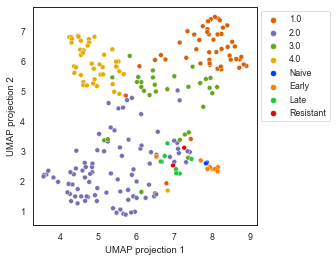

In [97]:
fig = plt.figure(figsize=(4, 4))
ax1 = fig.add_subplot(111)
# g1 = sns.scatterplot(
#     data=umap_df,
#     x='pc1', y='pc2', 
#     hue='source',
#     palette=['black', 'magenta'],
# #     palette=cluster_colors,
#     ax=ax1
# )
g1 = sns.scatterplot(
    data=umap_df,
    x='pc1', y='pc2', 
    hue='Cluster',
    hue_order=hue_order,
    palette=cluster_colors,
    ax=ax1
)
plt.legend(bbox_to_anchor=(1., 1.))
plt.xlabel("UMAP projection 1");
plt.ylabel("UMAP projection 2");

plt.savefig('pca_w_cell_line_update.pdf', bbox_inches='tight')

In [96]:
merged.shape

(230, 146)

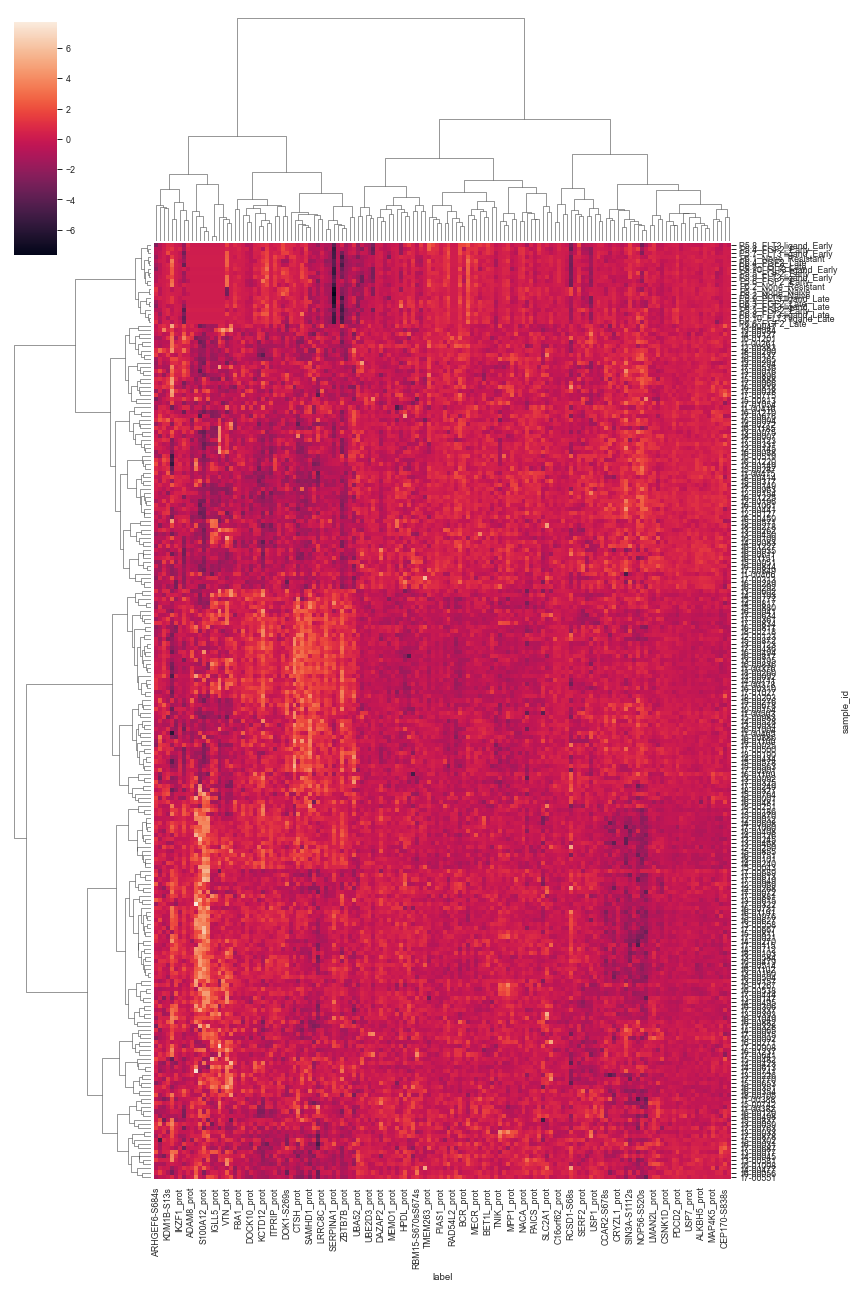

In [94]:
sns.clustermap(
    merged.fillna(0), 
    method='ward',
    metric='correlation',
    z_score=0,
    yticklabels=True,
    figsize=(12,18)
#     mask=merged.isnull()
)